# Riemannian Geodesics

In [177]:
#Modules
import jax.numpy as jnp
import jax.random as jrandom
from jax import vmap

from abc import ABC

import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.ticker as tkr

import os

from geometry.geodesics.riemannian import JAXOptimization, ScipyOptimization, GEORCE
from geometry.manifolds.riemannian import nEllipsoid, nSphere, nParaboloid, T2, RiemannianManifold

In [178]:
plt.rcParams.update({'font.size': 25})
cbformat = tkr.ScalarFormatter()   # create the formatter
cbformat.set_powerlimits((-2,2)) 

In [179]:
figure_path = '../figures/riemannian/geodesics/'

In [180]:
if not (os.path.exists(figure_path)):
    os.makedirs(figure_path)

## Hyper-Parameters

In [181]:
T=100
tol = 1e-4
max_iter = 100

jax_lr_rate = 0.01

### Estimation Plot 

In [182]:
def compute_estimates(M, Geodesic, z0, zT, base_curve):
    
    new_method = {}
    zt, grad, idx = Geodesic(z0,zT, "while")
    xt = vmap(lambda z: M.f(z))(zt)
    length = M.length(zt)
    
    new_method['zt'] = zt
    new_method['grad'] = grad
    new_method['idx'] = idx
    new_method['xt'] = xt
    new_method['length'] = length
    
    zt, grad, _ = Geodesic(z0,zT, "for")
    error_base_curve = vmap(lambda z: jnp.linalg.norm(z-base_curve))(zt)
    error_iter_curve = vmap(lambda z1,z2: jnp.linalg.norm(z1-z2))(zt[1:], zt[:-1])
    grad_curve = vmap(lambda z: jnp.linalg.norm(Geodesic.Denergy(z)))(zt)
    
    new_method['error_base_curve'] = error_base_curve
    new_method['error_iter_curve'] = error_iter_curve
    new_method['grad_curve'] = grad_curve
    
    return new_method

In [183]:
def compute_methods(M, z0, zT, rho=.9, max_iter=max_iter,
                   tol=tol, T=T):
    
    estimates = {}
    
    Geodesic = GEORCE(M=M,
                      init_fun=None,
                      T=T,
                      line_search_method="soft",
                      max_iter=max_iter,
                      line_search_params={'rho': rho}
                     )
    base_curve, *_ = Geodesic(z0,zT, "while")
    
    Geodesic = GEORCE(M=M,
                      init_fun=None,
                      T=T,
                      line_search_method="soft",
                      max_iter=max_iter,
                      line_search_params={'rho': rho}
                     )
    estimates['GEORCE'] = compute_estimates(M, Geodesic, z0, zT, base_curve)

    Geodesic = JAXOptimization(M = M,
                              init_fun=None,
                              lr_rate=jax_lr_rate,
                              optimizer=None,
                              T=T,
                              max_iter=max_iter,
                              tol=tol)
    estimates['ADAM'] = compute_estimates(M, Geodesic, z0, zT, base_curve)

    Geodesic = ScipyOptimization(M = M,
                                 T=T,
                                 tol=tol,
                                 max_iter=max_iter,
                                 method="BFGS",
                                )
    estimates['BFGS'] = compute_estimates(M, Geodesic, z0, zT, base_curve)
    
    zt = Geodesic.init_fun(z0,zT, T)
    xt = vmap(lambda z: M.f(z))(zt)
    length = M.length(zt)
    
    new_method = {}
    new_method['zt'] = zt
    new_method['grad'] = None
    new_method['idx'] = None
    new_method['xt'] = xt
    new_method['length'] = length
    estimates['Initilization'] = new_method
    
    if hasattr(M, "Geodesic"):
        xt = M.Geodesic(z0,zT)
        zt = vmap(M.invf)(xt)
        length = M.length(zt)
    else:
        xt = None
        zt = None
        length = None
        
    new_method = {}
    new_method['zt'] = zt
    new_method['grad'] = None
    new_method['idx'] = None
    new_method['xt'] = xt
    new_method['length'] = length
    estimates['Ground truth'] = new_method
    
    return estimates

## Estimating Geodesics

### Ellipsoid(2)

In [184]:
params = jnp.linspace(0.5,1.0,3)[::-1]
M = nEllipsoid(dim=2, params=params)
z0 = -jnp.linspace(0,1,2)
zT = jnp.ones(2, dtype=jnp.float32)

e2_x0 = M.f(z0)
e2_xT = M.f(zT)

ellipsoid_methods = compute_methods(M, z0, zT, rho=0.5)

/home/fmry/anaconda3/lib/python3.9/site-packages/scipy/optimize/_minimize.py:565: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  warn('Method %s does not use Hessian information (hess).' % method,
/home/fmry/anaconda3/lib/python3.9/site-packages/scipy/optimize/_minimize.py:571: RuntimeWarning: Method BFGS does not use Hessian-vector product information (hessp).
  warn('Method %s does not use Hessian-vector product '


### $\mathbb{S}^{2}$

In [185]:
M = nSphere(dim=2)
z0 = -jnp.linspace(0,1,2)
zT = jnp.ones(2, dtype=jnp.float32)

s2_x0 = M.f(z0)
s2_xT = M.f(zT)

sphere_methods = compute_methods(M, z0, zT, rho=0.5)

### Paraboloid(2)

In [186]:
M = nParaboloid(dim=2)
z0 = -jnp.linspace(0,1,2)
zT = jnp.ones(2)

p2_x0 = M.f(z0)
p2_xT = M.f(zT)

paraboloid_methods = compute_methods(M, z0, zT, rho=0.5)

### $\mathbb{T}^{2}$

In [187]:
M = T2(R=3.0, r=1.0)
z0 = jnp.array([0.0, 0.0])
zT = jnp.array([5*jnp.pi/4, 5*jnp.pi/4])

t2_x0 = M.f(z0)
t2_xT = M.f(zT)

torus_methods = compute_methods(M, z0, zT, rho=0.5)

## Plotting Geodesics

In [188]:
class EllipsoidPlot(ABC):
    def __init__(self, params=jnp.linspace(0.5,1.0,3)[::-1]):
        
        self.params = params

    def grid(self, n_points:int=100):
        
        theta = jnp.linspace(0.0, jnp.pi*1, n_points)
        phi   = jnp.linspace(0.0, jnp.pi*2, n_points)

        # Creating the coordinate grid for the unit sphere.
        x1 = jnp.outer(jnp.sin(theta), jnp.cos(phi))
        x2 = jnp.outer(jnp.sin(theta), jnp.sin(phi))
        x3 = jnp.outer(jnp.cos(theta), jnp.ones(n_points))
        
        return self.params[0]*x1,self.params[1]*x2,self.params[2]*x3
         

In [189]:
class TorusPlot(ABC):
    def __init__(self, R:float=3.0, r:float=1.0):
        
        self.R = R
        self.r = r
        
    def grid(self, n_points:int=100):
        
        U = jnp.linspace(0, 2*jnp.pi, n_points)
        V = jnp.linspace(0, 2*jnp.pi, n_points)
        U, V = jnp.meshgrid(U, V)
        X = (self.R+self.r*jnp.cos(V))*jnp.cos(U)
        Y = (self.R+self.r*jnp.cos(V))*jnp.sin(U)
        Z = self.r*jnp.sin(V)
        
        return X, Y, Z

In [190]:
class ParaboloidPlot(ABC):
    def __init__(self):
        
        return

    def grid(self, n_points:int=100):
        
        x1 = jnp.linspace(-2.0, 2.0, n_points)
        x2 = jnp.linspace(-2.0,2.0, n_points)
        
        X1, X2 = jnp.meshgrid(x1,x2)
        
        return X1, X2, X1**2+X2**2

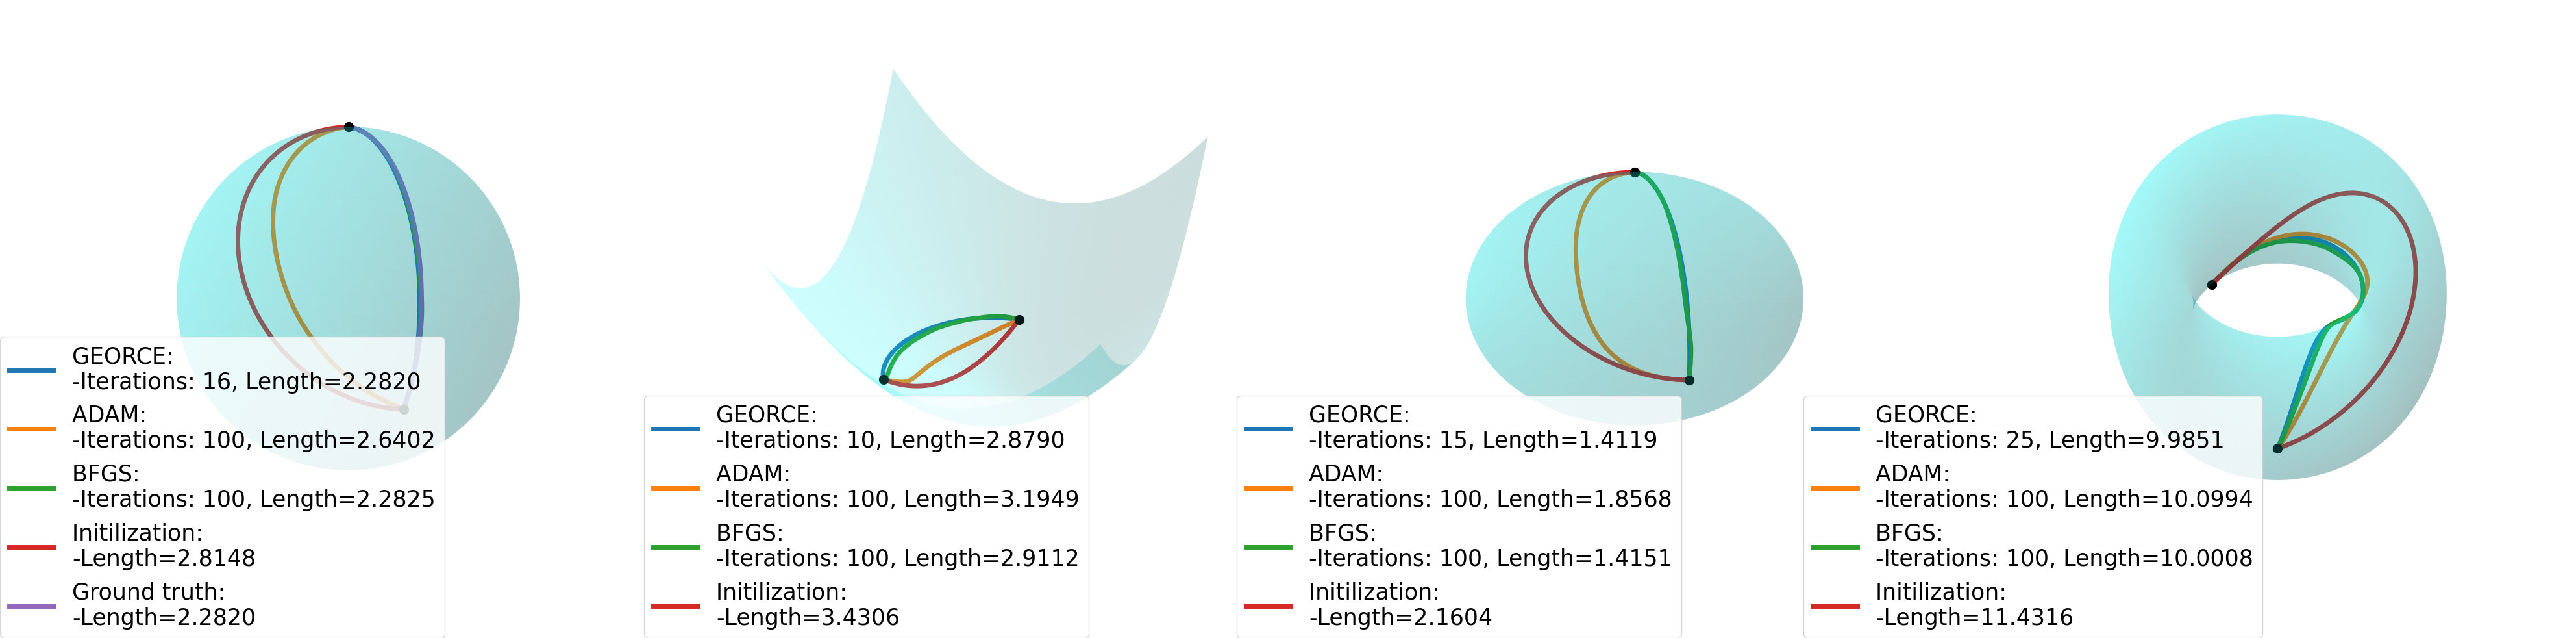

In [191]:
fig = plt.figure(figsize=(40,10))

#plotting sphere
plot_sphere = EllipsoidPlot(params=jnp.ones(3))
x1,x2,x3 = plot_sphere.grid(100)
ax = fig.add_subplot(141, projection='3d')
ax.plot_surface(x1, x2, x3, color='cyan', rstride=1, cstride=1, alpha=0.2)
for key, value in sphere_methods.items():
    if value['zt'] is not None:
        if value['idx'] is not None:
            ax.plot(value['xt'][:,0], value['xt'][:,1], value['xt'][:,2], alpha=1.0, 
                label=f"{key}: \n-Iterations: {value['idx']}, Length={value['length']:.4f}", linewidth=5.0)
        else:
            ax.plot(value['xt'][:,0], value['xt'][:,1], value['xt'][:,2], alpha=1.0, 
                    label=f"{key}: \n-Length={value['length']:.4f}", linewidth=5.0)
    
ax.scatter(s2_x0[0], s2_x0[1], s2_x0[2], color='black', alpha=1.0, s=100)
ax.scatter(s2_xT[0], s2_xT[1], s2_xT[2], color='black', alpha=1.0, s=100)
ax.set_box_aspect([1,1,1])
ax.set_xlim([-1.0,1.0])
ax.set_ylim([-1.0,1.0])
ax.set_zlim([-1.0,1.0])
ax.set_axis_off()
ax.view_init(elev=180., azim=90)
lines_labels = [ax.get_legend_handles_labels()]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
fig.legend(lines, labels, loc=(0.0,0.0), ncol=1)

#plotting paraboloid
plot_sphere = ParaboloidPlot()
x1,x2,x3 = plot_sphere.grid(100)
ax = fig.add_subplot(142, projection='3d')
ax.plot_surface(x1, x2, x3, color='cyan', rstride=1, cstride=1, alpha=0.2)
for key, value in paraboloid_methods.items():
    if value['zt'] is not None:
        if value['idx'] is not None:
            ax.plot(value['xt'][:,0], value['xt'][:,1], value['xt'][:,2], alpha=1.0, 
                label=f"{key}: \n-Iterations: {value['idx']}, Length={value['length']:.4f}", linewidth=5.0)
        else:
            ax.plot(value['xt'][:,0], value['xt'][:,1], value['xt'][:,2], alpha=1.0, 
                    label=f"{key}: \n-Length={value['length']:.4f}", linewidth=5.0)

    
ax.scatter(p2_x0[0], p2_x0[1], p2_x0[2], color='black', alpha=1.0, s=100)
ax.scatter(p2_xT[0], p2_xT[1], p2_xT[2], color='black', alpha=1.0, s=100)
#ax.set_box_aspect([1,1,1])
#ax.set_xlim([-1.0,1.0])
#ax.set_ylim([-1.0,1.0])
#ax.set_zlim([-1.0,1.0])
ax.set_axis_off()
ax.view_init(elev=40., azim=110.)
lines_labels = [ax.get_legend_handles_labels()]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
fig.legend(lines, labels, loc=(0.25,0.0), ncol=1)

#plotting Ellipsoid
plot_sphere = EllipsoidPlot()
x1,x2,x3 = plot_sphere.grid(100)
ax = fig.add_subplot(143, projection='3d')
ax.plot_surface(x1, x2, x3, color='cyan', rstride=1, cstride=1, alpha=0.2)
for key, value in ellipsoid_methods.items():
    if value['zt'] is not None:
        if value['idx'] is not None:
            ax.plot(value['xt'][:,0], value['xt'][:,1], value['xt'][:,2], alpha=1.0, 
                label=f"{key}: \n-Iterations: {value['idx']}, Length={value['length']:.4f}", linewidth=5.0)
        else:
            ax.plot(value['xt'][:,0], value['xt'][:,1], value['xt'][:,2], alpha=1.0, 
                    label=f"{key}: \n-Length={value['length']:.4f}", linewidth=5.0)
    
ax.scatter(e2_x0[0], e2_x0[1], e2_x0[2], color='black', alpha=1.0, s=100)
ax.scatter(e2_xT[0], e2_xT[1], e2_xT[2], color='black', alpha=1.0, s=100)
#ax.set_box_aspect([1,1,1])
#ax.set_xlim([-1.0,1.0])
#ax.set_ylim([-1.0,1.0])
#ax.set_zlim([-1.0,1.0])
ax.set_axis_off()
ax.view_init(elev=180., azim=90)
lines_labels = [ax.get_legend_handles_labels()]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
fig.legend(lines, labels, loc=(0.48, 0.0), ncol=1)

#plotting Torus
plot_sphere = TorusPlot(R=3.0, r=1.0)
x1,x2,x3 = plot_sphere.grid(100)
ax = fig.add_subplot(144, projection='3d')
ax.plot_surface(x1, x2, x3, color='cyan', rstride=1, cstride=1, alpha=0.2)
for key, value in torus_methods.items():
    if value['zt'] is not None:
        if value['idx'] is not None:
            ax.plot(value['xt'][:,0], value['xt'][:,1], value['xt'][:,2], alpha=1.0, 
                label=f"{key}: \n-Iterations: {value['idx']}, Length={value['length']:.4f}", linewidth=5.0)
        else:
            ax.plot(value['xt'][:,0], value['xt'][:,1], value['xt'][:,2], alpha=1.0, 
                    label=f"{key}: \n-Length={value['length']:.4f}", linewidth=5.0)

    
ax.scatter(t2_x0[0], t2_x0[1], t2_x0[2], color='black', alpha=1.0, s=100)
ax.scatter(t2_xT[0], t2_xT[1], t2_xT[2], color='black', alpha=1.0, s=100)
#ax.set_box_aspect([1,1,1])
#ax.set_xlim([-1.0,1.0])
#ax.set_ylim([-1.0,1.0])
#ax.set_zlim([-1.0,1.0])
ax.set_axis_off()
ax.view_init(elev=60., azim=0)
lines_labels = [ax.get_legend_handles_labels()]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
fig.legend(lines, labels, loc=(0.70, 0.0), ncol=1)

fig.tight_layout()

save_path = f'{figure_path}synthetic_riemannian_geodesics.pdf'
fig.savefig(save_path, format='pdf', pad_inches=0.1, bbox_inches='tight')

plt.show()




## Plotting Gradients

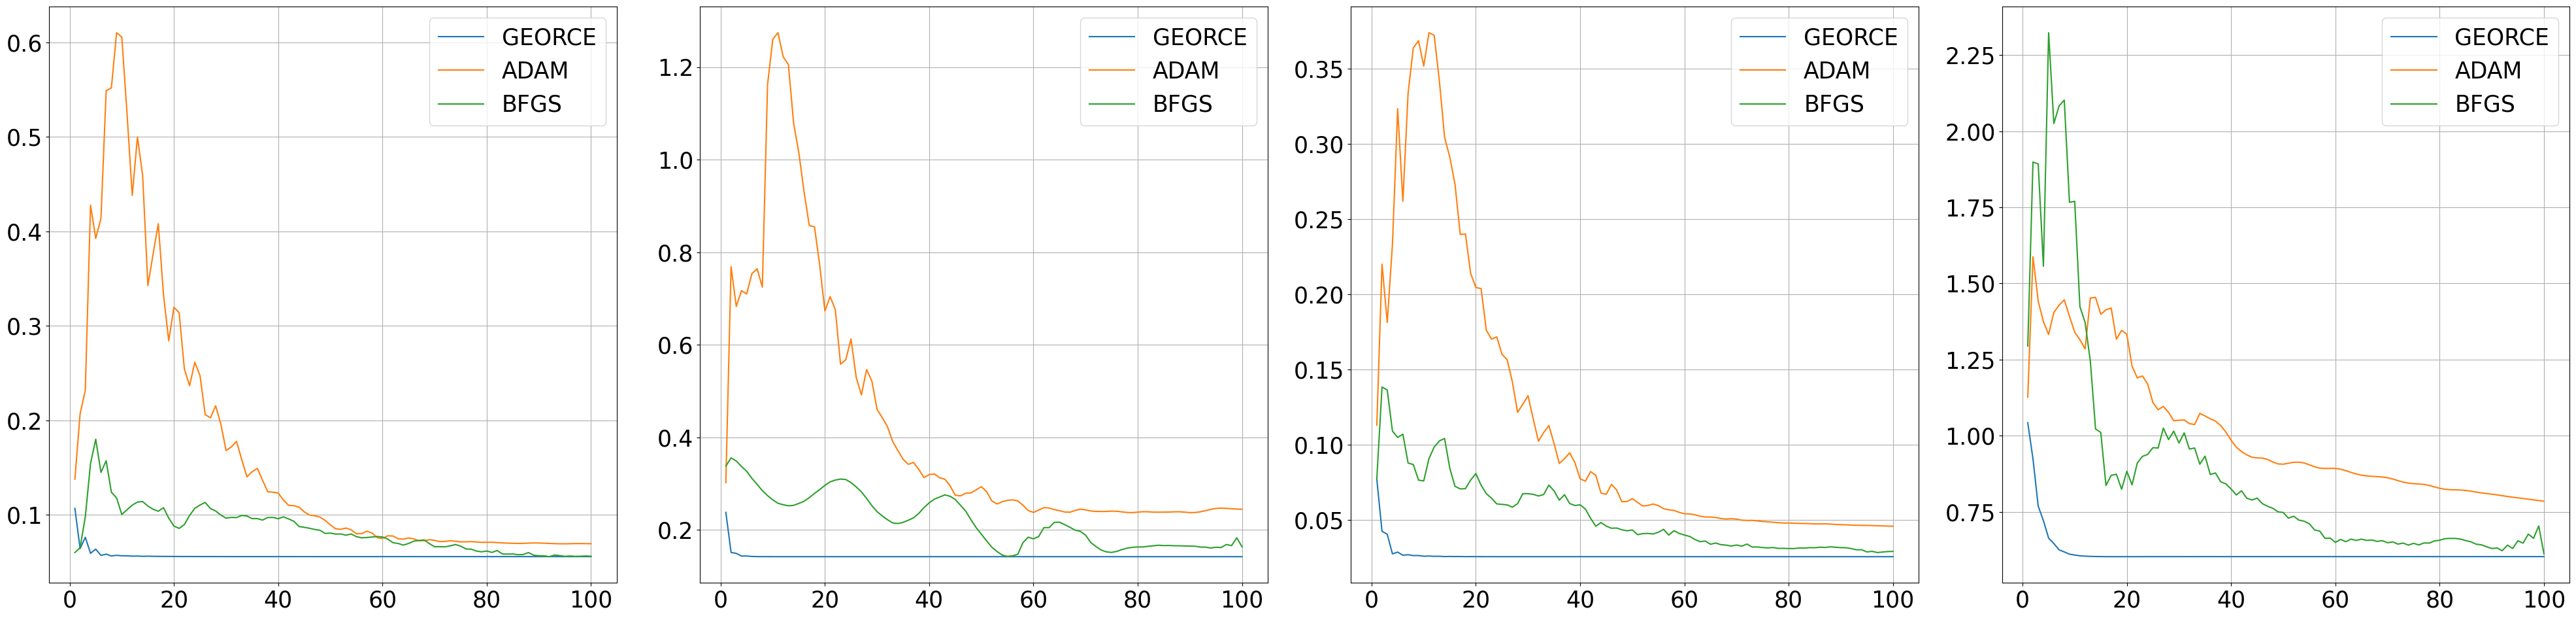

In [192]:
fig = plt.figure(figsize=(40,10))

ax = fig.add_subplot(141)
for key, value in sphere_methods.items():
    if value['grad'] is not None:
        ax.plot(jnp.arange(1,len(value['grad_curve'])+1,1), value['grad_curve'], 
                alpha=1.0, label=f"{key}")
ax.grid(True)
ax.legend(loc='upper right')

ax = fig.add_subplot(142)
for key, value in paraboloid_methods.items():
    if value['grad'] is not None:
        ax.plot(jnp.arange(1,len(value['grad_curve'])+1,1), value['grad_curve'], 
                alpha=1.0, label=f"{key}")
ax.grid(True)
ax.legend(loc='upper right')

ax = fig.add_subplot(143)
for key, value in ellipsoid_methods.items():
    if value['grad'] is not None:
        ax.plot(jnp.arange(1,len(value['grad_curve'])+1,1), value['grad_curve'], 
                alpha=1.0, label=f"{key}")
ax.grid(True)
ax.legend(loc='upper right')

ax = fig.add_subplot(144)
for key, value in torus_methods.items():
    if value['grad'] is not None:
        ax.plot(jnp.arange(1,len(value['grad_curve'])+1,1), value['grad_curve'], 
                alpha=1.0, label=f"{key}")
ax.grid(True)
ax.legend(loc='upper right')

fig.tight_layout()

save_path = f'{figure_path}synthetic_riemannian_gradients.pdf'
fig.savefig(save_path, format='pdf', pad_inches=0.1, bbox_inches='tight')

plt.show()



## Plotting Convergence

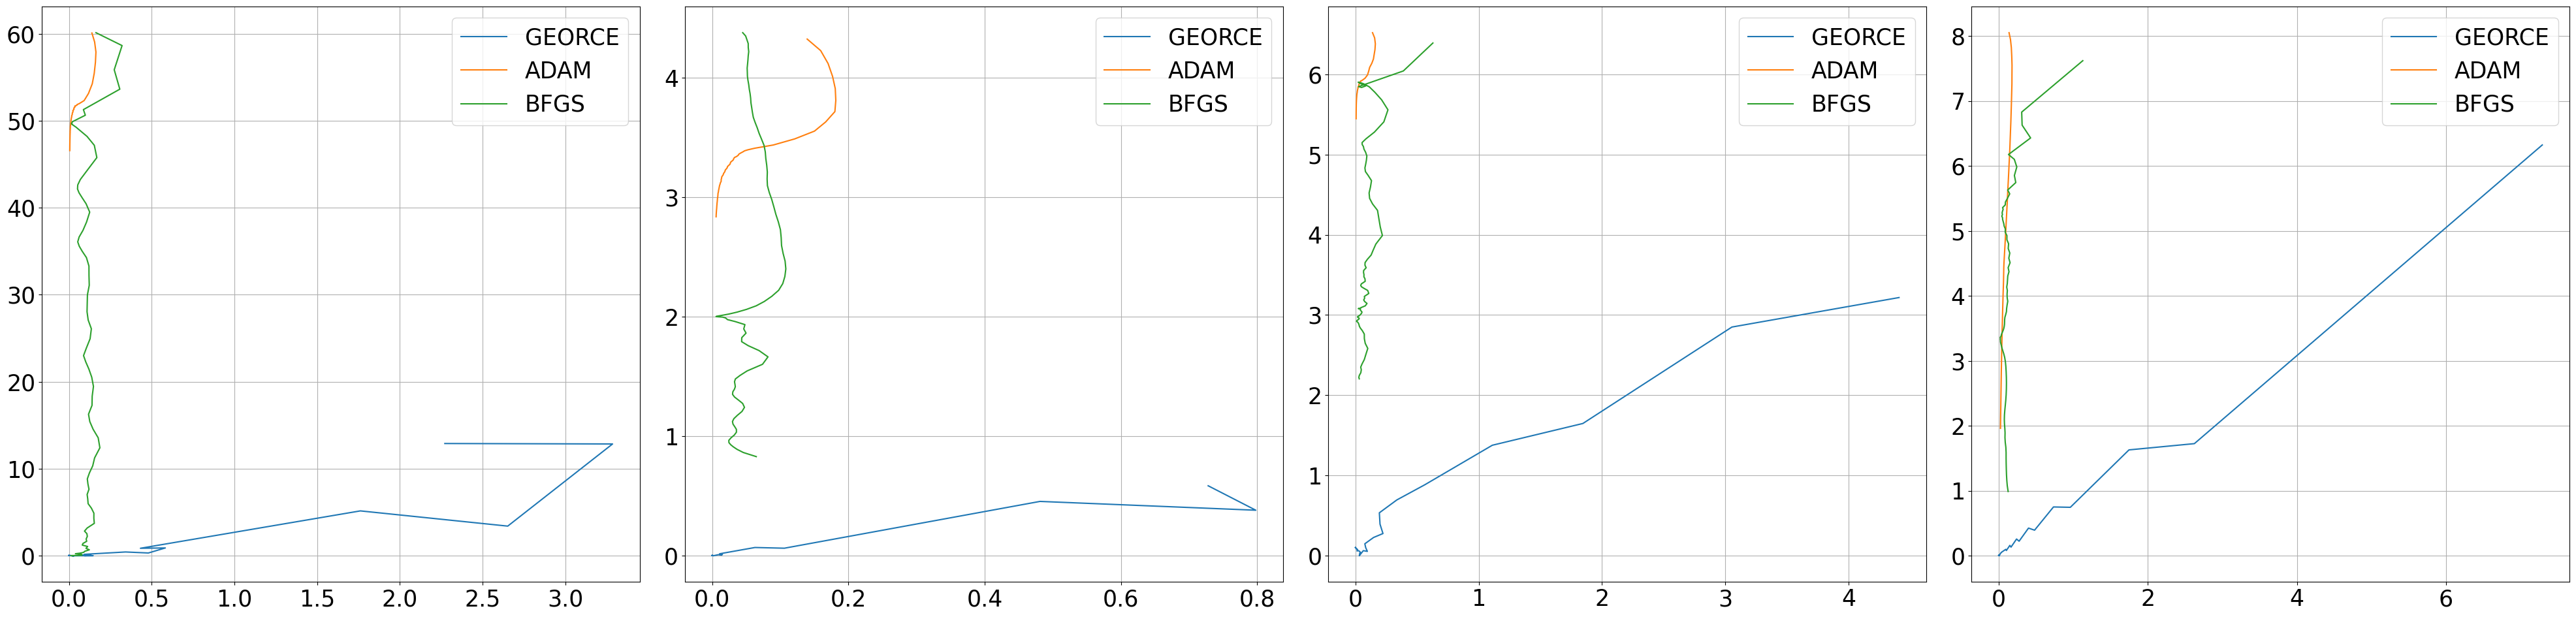

In [193]:
fig = plt.figure(figsize=(40,10))

ax = fig.add_subplot(141)
for key, value in sphere_methods.items():
    if value['grad'] is not None:
        ax.plot(value['error_iter_curve'], value['error_base_curve'][:-1]**2, 
                alpha=1.0, label=f"{key}")
ax.grid(True)
ax.legend(loc='upper right')

ax = fig.add_subplot(142)
for key, value in paraboloid_methods.items():
    if value['grad'] is not None:
        ax.plot(value['error_iter_curve'], value['error_base_curve'][:-1], 
                alpha=1.0, label=f"{key}")
ax.grid(True)
ax.legend(loc='upper right')

ax = fig.add_subplot(143)
for key, value in ellipsoid_methods.items():
    if value['grad'] is not None:
        ax.plot(value['error_iter_curve'], value['error_base_curve'][:-1], 
                alpha=1.0, label=f"{key}")
ax.grid(True)
ax.legend(loc='upper right')

ax = fig.add_subplot(144)
for key, value in torus_methods.items():
    if value['grad'] is not None:
        ax.plot(value['error_iter_curve'], value['error_base_curve'][:-1], 
                alpha=1.0, label=f"{key}")
ax.grid(True)
ax.legend(loc='upper right')

fig.tight_layout()

save_path = f'{figure_path}synthetic_riemannian_convergence.pdf'
fig.savefig(save_path, format='pdf', pad_inches=0.1, bbox_inches='tight')

plt.show()



## Alternative Experiments 

### Cut Loci on the Paraboloid and Egg-landshape

#### Egg Landshape

In [194]:
def f_fun(z):
    
    x, y = z[0], z[1]
    
    return jnp.array([x,y,2.0*jnp.cos(x)*jnp.cos(y)])
    

In [195]:
M = RiemannianManifold(f=f_fun)
z0 = 5*jnp.array([-1.,-1.])
zT = 5*jnp.array([1.0,1.])

egg_x0 = M.f(z0)
egg_xT = M.f(zT)

egg_methods = compute_methods(M, z0, zT, rho=0.5, T=1000, max_iter=1000)

/home/fmry/anaconda3/lib/python3.9/site-packages/scipy/optimize/_minimize.py:565: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  warn('Method %s does not use Hessian information (hess).' % method,
/home/fmry/anaconda3/lib/python3.9/site-packages/scipy/optimize/_minimize.py:571: RuntimeWarning: Method BFGS does not use Hessian-vector product information (hessp).
  warn('Method %s does not use Hessian-vector product '


#### Paraboloid

In [196]:
M = nParaboloid(dim=2)
z0 = -1.5*jnp.ones(2)
zT = 1.5*jnp.ones(2)

p2_x0 = M.f(z0)
p2_xT = M.f(zT)

cut_loci_paraboloid_methods = compute_methods(M, z0, zT, rho=0.5, T=100, max_iter=1000)

/home/fmry/anaconda3/lib/python3.9/site-packages/scipy/optimize/_minimize.py:565: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  warn('Method %s does not use Hessian information (hess).' % method,
/home/fmry/anaconda3/lib/python3.9/site-packages/scipy/optimize/_minimize.py:571: RuntimeWarning: Method BFGS does not use Hessian-vector product information (hessp).
  warn('Method %s does not use Hessian-vector product '


### Plotting 

In [197]:
class ParaboloidPlot(ABC):
    def __init__(self):
        
        return

    def grid(self, n_points:int=100):
        
        x1 = jnp.linspace(-3.0, 3.0, n_points)
        x2 = jnp.linspace(-3.0,3.0, n_points)
        
        X1, X2 = jnp.meshgrid(x1,x2)
        
        return X1, X2, X1**2+X2**2

In [198]:
class EggPlot(ABC):
    def __init__(self):
        
        return

    def grid(self, n_points:int=100):
        
        x1 = jnp.linspace(-10.0, 10.0, n_points)
        x2 = jnp.linspace(-10.0,10.0, n_points)
        
        X1, X2 = jnp.meshgrid(x1,x2)
        
        return X1, X2, 2.0*jnp.cos(X1)*jnp.cos(X2)

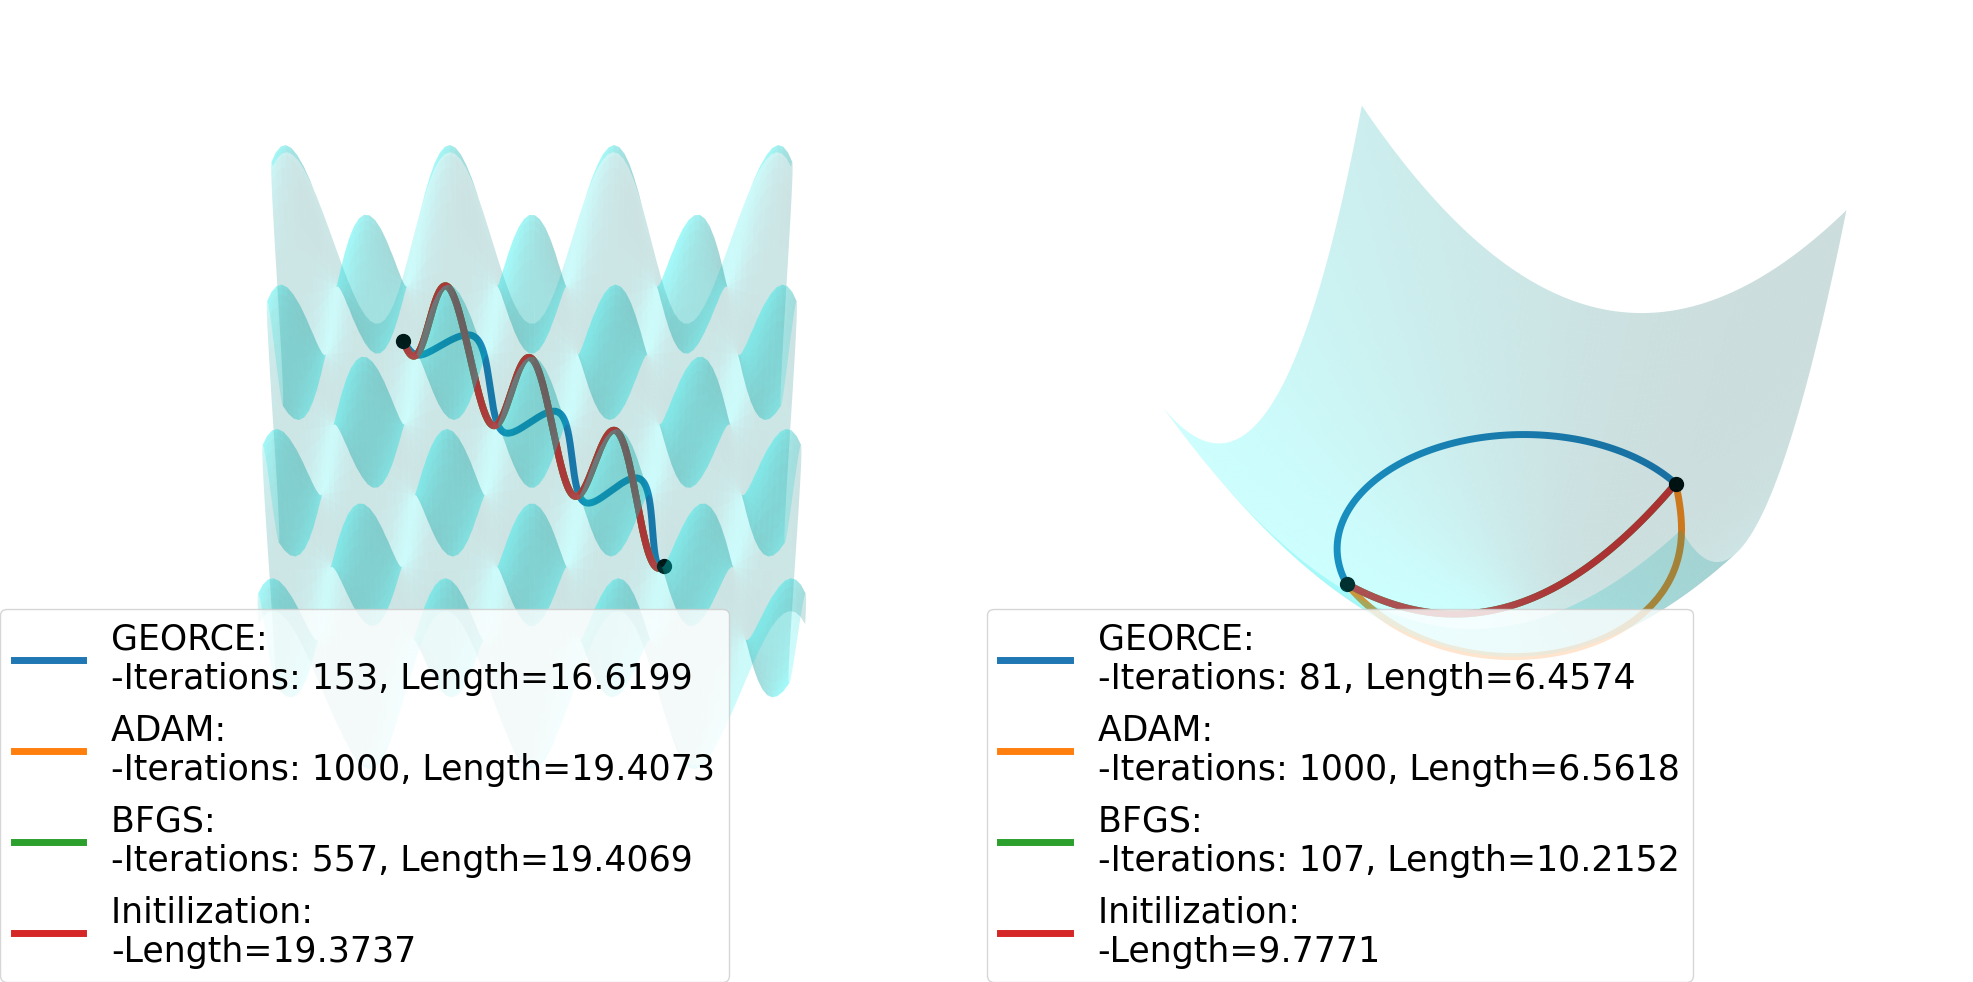

In [199]:
fig = plt.figure(figsize=(20, 10))

#plotting sphere
plot_sphere = EggPlot()
x1,x2,x3 = EggPlot.grid(100)
ax = fig.add_subplot(121, projection='3d')
ax.plot_surface(x1, x2, x3, color='cyan', rstride=1, cstride=1, alpha=0.2)
for key, value in egg_methods.items():
    if value['zt'] is not None:
        if value['idx'] is not None:
            ax.plot(value['xt'][:,0], value['xt'][:,1], value['xt'][:,2], alpha=1.0, 
                label=f"{key}: \n-Iterations: {value['idx']}, Length={value['length']:.4f}", linewidth=5.0)
        else:
            ax.plot(value['xt'][:,0], value['xt'][:,1], value['xt'][:,2], alpha=1.0, 
                    label=f"{key}: \n-Length={value['length']:.4f}", linewidth=5.0)
ax.set_axis_off()
ax.view_init(elev=60., azim=0.)
lines_labels = [ax.get_legend_handles_labels()]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
fig.legend(lines, labels, loc=(0.0, 0.0), ncol=1)

ax.scatter(egg_x0[0], egg_x0[1], egg_x0[2], color='black', alpha=1.0, s=100)
ax.scatter(egg_xT[0], egg_xT[1], egg_xT[2], color='black', alpha=1.0, s=100)

#plotting paraboloid
plot_sphere = ParaboloidPlot()
x1,x2,x3 = plot_sphere.grid(100)
ax = fig.add_subplot(122, projection='3d')
ax.plot_surface(x1, x2, x3, color='cyan', rstride=1, cstride=1, alpha=0.2)
for key, value in cut_loci_paraboloid_methods.items():
    if value['zt'] is not None:
        if value['idx'] is not None:
            ax.plot(value['xt'][:,0], value['xt'][:,1], value['xt'][:,2], alpha=1.0, 
                label=f"{key}: \n-Iterations: {value['idx']}, Length={value['length']:.4f}", linewidth=5.0)
        else:
            ax.plot(value['xt'][:,0], value['xt'][:,1], value['xt'][:,2], alpha=1.0, 
                    label=f"{key}: \n-Length={value['length']:.4f}", linewidth=5.0)
            
ax.scatter(p2_x0[0], p2_x0[1], p2_x0[2], color='black', alpha=1.0, s=100)
ax.scatter(p2_xT[0], p2_xT[1], p2_xT[2], color='black', alpha=1.0, s=100)

#ax.set_box_aspect([1,1,1])
#ax.set_xlim([-1.0,1.0])
#ax.set_ylim([-1.0,1.0])
#ax.set_zlim([-1.0,1.0])
ax.set_axis_off()
ax.view_init(elev=40., azim=110.)
lines_labels = [ax.get_legend_handles_labels()]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
fig.legend(lines, labels, loc=(0.5,0.0), ncol=1)

fig.tight_layout()

save_path = f'{figure_path}extra_riemannian_geodesics.pdf'
fig.savefig(save_path, format='pdf', pad_inches=0.1, bbox_inches='tight')

plt.show()


